**Imports and Model Setup**

In [1]:
import torch

print("PyTorch version:", torch.__version__)  # Should show CUDA version
print("CUDA version in PyTorch:", torch.version.cuda)  # Should match installed CUDA (e.g., 12.1)
print("CUDA available:", torch.cuda.is_available())  # Should return True
print("Number of GPUs:", torch.cuda.device_count())  # Should be > 0
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

PyTorch version: 2.2.0+cu118
CUDA version in PyTorch: 11.8
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tifffile
from PIL import Image
import glob
from pathlib import Path
import timm.layers
import tqdm
import cv2
import torch

In [3]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "model/MobileSAM_Vortex_checkpoint.pth"
device = "cpu"  # set device to cpu temporarily for dataset transforms

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)

predictor = SamPredictor(mobile_sam)
mask_generator = SamAutomaticMaskGenerator(mobile_sam)

c:\Users\juhye\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\juhye\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\juhye\AppData\Local\Programs\Python\Python312\Lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\juhye\AppD

**Generate Dataset**

## Data

Preparing Data for training/validation (not yet test). Training and validation process using PyTorch requires two main implementations: `Dataset`, `Dataloader`.  

In [4]:
import os
import os.path as osp
import torch
import numpy as np
import cv2
from patchify import patchify
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import namedtuple


ImageMaskPathItem = namedtuple("ImageMaskPathItem", ["image_path", "mask_path"])

class ImageMaskDataset(Dataset):
    def __init__(self, root, image_subdir, mask_subdir, transform=None):
        super().__init__()
        self.root = root
        self.image_subdir = image_subdir
        self.mask_subdir = mask_subdir
        self.transform = transform

        images = glob.glob(osp.join(root, image_subdir, "*.png"))
        images = sorted(images)
        masks = [image.replace(image_subdir, mask_subdir) for image in images]

        self.path_items = [ImageMaskPathItem(image_path=image, mask_path=mask) for image, mask in zip(images, masks)]
        self._sanity_check()
        print(f"Found {len(self.path_items)} image-mask pairs")

    def _sanity_check(self):
        for item in self.path_items:
            assert osp.exists(item.image_path), f"Image path {item.image_path} does not exist"
            assert osp.exists(item.mask_path), f"Mask path {item.mask_path} does not exist"

    def __getitem__(self, index):
        item = self.path_items[index]
        image = np.array(Image.open(item.image_path).convert("RGB"))
        mask = np.array(Image.open(item.mask_path).convert("L"))
        # image = cv2.imread(item.image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # FIXME: Check if this is necessary
        # mask = cv2.imread(item.mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

    def __len__(self):
        return len(self.path_items)

In [5]:
import torch
from mobile_sam.utils import transforms
from torchvision import transforms as T
from torch.utils.data import Subset

# Strongly recommended libraries for image augmentation (especially for segmentation tasks):
# Run `pip install albumentations` to install them
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose(
    [
        A.Normalize(max_pixel_value=255.0),
        ToTensorV2(),
    ], is_check_shapes = False #disabel size match verificaiton between img and mask
)

train_ds = ImageMaskDataset(root="processed_data", image_subdir="images", mask_subdir="masks", transform=transform)
val_ds = ImageMaskDataset(root="processed_data", image_subdir="images", mask_subdir="masks", transform=transform)

indices = np.arange(len(train_ds))
train_idx, val_idx = train_test_split(indices, test_size=0.2, shuffle=True, random_state=42)
train_ds = Subset(train_ds, train_idx)
val_ds = Subset(val_ds, val_idx)

#train_ds, val_ds = train_test_split(ds, test_size=0.2, random_state=42)
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

print("Train dataset sample:")
print(train_ds[0][0].dtype)
print(train_ds[0][0].shape)
print(train_ds[0][1].shape)

Found 8443 image-mask pairs
Found 8443 image-mask pairs
Train dataset size: 6754
Validation dataset size: 1689
Train dataset sample:
torch.float32
torch.Size([3, 1024, 1024])
torch.Size([256, 256])


In [6]:
BATCH_SIZE = 4
NUM_WORKERS = 0

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

**Dataset Processor for MobileSAM**

In [8]:
#######################################################################################################################
###### FIXME: Do we need ResizeLongestSide, since we already patchified the images into fixed size patches? ###########
#######################################################################################################################

# import torch
# from mobile_sam.utils import transforms

# # Image transforms
# transform = transforms.ResizeLongestSide(mobile_sam.image_encoder.img_size)

# transformed_images = []
# for raw in filtered_raw:
#     transformed_image = torch.as_tensor(transform.apply_image(raw), device="cpu")
#     transformed_image = transformed_image.permute(2, 0, 1)
#     transformed_images.append(transformed_image)

# # Box transforms
# transformed_boxes = []
# for box in filtered_boxes:
#     transformed_box = torch.as_tensor(transform.apply_boxes(box, (256, 256)), dtype=torch.float, device="cuda")[None, :]
#     transformed_boxes.append(transformed_box)

# # GT Mask transforms
# transformed_masks = []
# for mask in filtered_masked:
#     transformed_mask = torch.from_numpy(mask).float()
#     transformed_masks.append(transformed_mask)

In [9]:
# batch_size = 8
# train_batch = []
# val_batch = []
# current_batch = []

# # train_batch fill
# for img, boxes, mask in zip(train_images, train_boxes, train_masks):
#     sample = {
#         "image": img,  # The image tensor
#         "original_size": (256, 256),  # Original size of the image
#         "boxes": boxes.requires_grad_().to("cuda"),  # Boxes for this image
#         "ground_truth_mask": mask.to("cuda").requires_grad_(),
#     }
#     current_batch.append(sample)

#     if len(current_batch) == batch_size:
#         train_batch.append(current_batch)
#         current_batch = []

# if current_batch:
#     train_batch.append(current_batch)

# # val_batch fill
# for img, boxes, mask in zip(val_images, val_boxes, val_masks):
#     sample = {
#         "image": img,  # The image tensor
#         "original_size": (256, 256),  # Original size of the image
#         "boxes": boxes.requires_grad_().to("cuda"),  # Boxes for this image
#         "ground_truth_mask": mask.to("cuda").requires_grad_(),
#     }
#     current_batch.append(sample)

#     if len(current_batch) == batch_size:
#         val_batch.append(current_batch)
#         current_batch = []

# if current_batch:
#     val_batch.append(current_batch)

In [10]:
# # Save dataset
# torch.save(train_batch, "./captures/train_batch.pt")
# torch.save(val_batch, "./captures/val_batch.pt")

**Reset Model for Training**

In [11]:
# train_batch = torch.load("./captures/train_batch.pt")
# val_batch = torch.load("./captures/val_batch.pt")
# train_images = torch.load('./captures/filtered_raw.pt')
# train_masks = torch.load('./captures/filtered_masked.pt')
# train_boxes = torch.load('./captures/filtered_boxes.pt')

In [7]:
from mobile_sam import sam_model_registry, SamPredictor

model_type = "vit_t"
sam_checkpoint = "model/MobileSAM_Vortex_checkpoint.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry["vit_t"](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
predictor = SamPredictor(mobile_sam)

In [8]:
# Freeze layers in MobileSAM
for name, param in mobile_sam.named_parameters():
    if name.startswith("image_encoder"):  # Assuming "image_encoder" corresponds to the vision encoder
        param.requires_grad = False  # Freeze the vision encoder
    elif name.startswith("prompt_encoder"):  # Assuming "prompt_encoder" exists in MobileSAM
        param.requires_grad = False  # Freeze the prompt encoder

# Verify trainable parameters
trainable_params = sum(p.numel() for p in mobile_sam.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# Iterate through all parameters and check their trainable status
print("MobileSAM Parameters:")
for name, param in mobile_sam.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Count the total trainable parameters
trainable_params = sum(p.numel() for p in mobile_sam.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters in MobileSAM: {trainable_params}")

Trainable parameters: 4058340
MobileSAM Parameters:
image_encoder.patch_embed.seq.0.c.weight: Frozen
image_encoder.patch_embed.seq.0.bn.weight: Frozen
image_encoder.patch_embed.seq.0.bn.bias: Frozen
image_encoder.patch_embed.seq.2.c.weight: Frozen
image_encoder.patch_embed.seq.2.bn.weight: Frozen
image_encoder.patch_embed.seq.2.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv1.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv1.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv1.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv2.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv2.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv2.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv3.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv3.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv3.bn.bias: Frozen
image_encoder.layers.0.blocks.1.conv1.c.weight: Frozen
image_encoder.layers.0.blocks.1.conv1.bn.weight: Frozen
image_encoder.layers.0.blocks.1.conv1.bn.bias: F

**Training Loop**

In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the optimizer for the mask decoder
optimizer = Adam(mobile_sam.mask_decoder.parameters(), lr=5e-4, weight_decay=0)


from torch import nn
from torch.nn import functional as F


class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction="mean")
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


# Define the segmentation loss function
# You can choose between DiceFocalLoss, FocalLoss, or DiceCELoss
seg_loss = DiceBCELoss()

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

c:\Users\juhye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
from tqdm import tqdm
from statistics import mean
import torch
import math

# Training loop
num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
mobile_sam.to(device)

mobile_sam.train()
for epoch in range(num_epochs):
    train_losses = []
    for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # stacking mask/training model/mask retrieve
        images, masks = batch
        images = images.to(device)
        masks = (masks / 255).round().float().to(device)
        # mask_batch = torch.stack([sample["ground_truth_mask"].unsqueeze(0).to(device) for sample in batch_group])  # 8 masked images rgb
        batched_input = [{"image": img, "original_size": (256, 256)} for img in images]  # FIXME: Check if this is the right way to pass the input
        outputs = mobile_sam(batched_input=batched_input, multimask_output=False)  # requires the whole batch
        predicted_masks = torch.stack([output["masks"].squeeze(1).float() for output in outputs])

        # loss calculation/optimization
        train_loss = seg_loss(predicted_masks, masks)
        train_losses.append(train_loss.item())
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if (len(train_losses)) % 100 == 0:
            print(f"Batch {len(train_losses)+1}/{len(train_dl)} - Training Loss: {train_loss.item():.2f}")

    mean_train_loss = mean(train_losses)
    train_losses.clear()

    # Validation loss calculation
    mobile_sam.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(val_dl, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = batch
            images = images.to(device)
            masks = (masks / 255).round().float().to(device)
            # mask_batch = torch.stack([sample["ground_truth_mask"].unsqueeze(0).to(device) for sample in batch_group])
            batched_input = [{"image": img, "original_size": (256, 256)} for img in images]  # FIXME: Check if this is the right way to pass the input
            outputs = mobile_sam(batched_input=batched_input, multimask_output=False)
            predicted_masks = torch.stack([output["masks"].squeeze(1).float() for output in outputs])
            val_loss = seg_loss(predicted_masks, masks)
            val_losses.append(val_loss.item())
    mean_val_loss = mean(val_losses)

    print(f"EPOCH: {epoch + 1}/{num_epochs} - Train Loss: {mean_train_loss:.4f} | Val Loss: {mean_val_loss:.4f}")
    scheduler.step(val_loss)
    # mobile_sam.train()

Epoch 1/10 - Training:   0%|          | 0/1689 [00:00<?, ?it/s]

Epoch 1/10 - Training:   6%|▌         | 100/1689 [03:52<42:18,  1.60s/it] 

Batch 101/1689 - Training Loss: 1.01


Epoch 1/10 - Training:  12%|█▏        | 200/1689 [05:20<20:00,  1.24it/s]

Batch 201/1689 - Training Loss: 1.02


Epoch 1/10 - Training:  18%|█▊        | 300/1689 [06:27<19:03,  1.21it/s]

Batch 301/1689 - Training Loss: 1.01


Epoch 1/10 - Training:  22%|██▏       | 369/1689 [07:16<26:01,  1.18s/it]


KeyboardInterrupt: 

In [11]:
# Save the state_dict after moving layers
torch.save(mobile_sam.state_dict(), "model/Vortex0214_02.pth")

**Inference**

In [12]:
from mobile_sam import sam_model_registry, SamPredictor

vortex_model = sam_model_registry["vit_t"](checkpoint="model/Vortex0214_02.pth")
vortex_model.eval()
predictor = SamPredictor(vortex_model)

-10.8130665 4.4362707


Text(0.5, 1.0, 'GT')

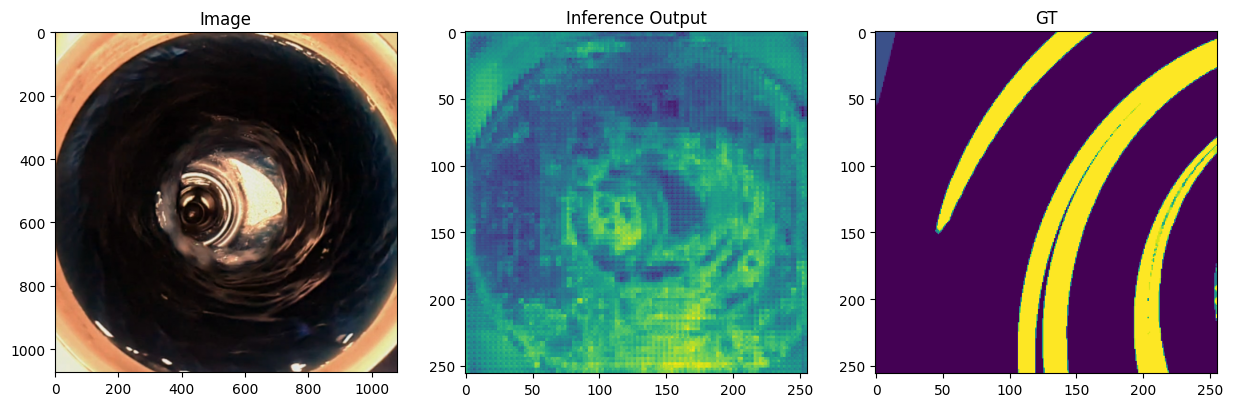

In [35]:
filename = "00029_p4"
test_image = cv2.imread(f"processed_data/images/{filename}.png", cv2.IMREAD_COLOR)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.imread("test.jpg", cv2.COLOR_BGR2RGB)
test_gt = cv2.imread(f"processed_data/masks/{filename}.png", cv2.IMREAD_GRAYSCALE)

vortex_model.cuda()

transformed = transform(image=test_image)['image']
batched_input = [{"image": transformed.cuda(), "original_size": (256, 256)}]  # FIXME: Check if this is the right way to pass the input
pred_mask = vortex_model(batched_input=batched_input, multimask_output=False)[0]["masks"]
pred_mask = pred_mask.squeeze().detach().cpu().numpy()
print(pred_mask.min(), pred_mask.max())
#pred_mask = (pred_mask > 0.5)
# predictor.set_image(np.array(test_image))

# my_ouput_mask, _, my_ouput_prob = predictor.predict(multimask_output=False)
# my_ouput_mask = np.array(my_ouput_mask.transpose(1, 2, 0), dtype=np.float32)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_image)
axes[0].set_title("Image")
axes[1].imshow(pred_mask)
axes[1].set_title("Inference Output")
axes[2].imshow(test_gt)
axes[2].set_title("GT")